In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()


unzip("archive.zip")

Found 16854 files belonging to 33 classes.


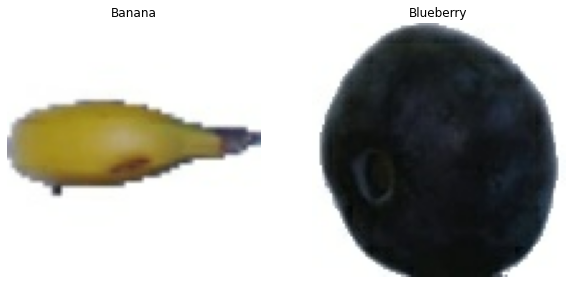

In [4]:
def random_image():
    image = image_dataset_from_directory(
        directory = "train/train",
        shuffle = True,
        image_size = (100,100),
        batch_size = 32,
    )

    class_names = image.class_names

    plt.figure(figsize=(10,10))
    for images,labels in image.take(2):
        for i in range(2):
            ax = plt.subplot(1,2,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

random_image()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 10,
    zoom_range = 0.1,
    validation_split = 0.2,
)

train_ds = datagen.flow_from_directory(
    directory = "train/train",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "training",
)

val_ds = datagen.flow_from_directory(
    directory = "train/train",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "validation",
)

Found 13493 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.


### Model: Transfer VGG16 (Fine Tuning)

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import vgg16, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

rescale = vgg16.preprocess_input
base_model = VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = True
base_model.summary()

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

class Transfer_VGG16():
    def model(self,input):
        self.x = rescale(input)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(128,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.x = Dense(64,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.output = Dense(33,activation="softmax")(self.x)
        self.model = Model(input,self.output,name="Transfer_VGG16")
        return self.model

TVGG16 = Transfer_VGG16()
model = TVGG16.model(Input(shape=(224,224,3)))
model.compile(Adam(1e-5),CategoricalCrossentropy(),metrics=["accuracy"])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    checkpoint = ModelCheckpoint("fruit.hdf5",save_weights_only=False,monitor="val_accuracy",save_beest_only=True)
    model.fit(train_ds,epochs=1,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("fruit.hdf5")
    val_loss,val_acc = best.evaluate(val_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_acc))
    print("Val loss: {:.2f} %".format(100*val_loss))

106/106 [==============================] - 35s 324ms/step - loss: 0.0161 - accuracy: 0.9985

Val accuracy: 99.85 %
Val loss: 1.61 %
